### 8.1. 시퀀스를 입력 시퀀스로 변환하기
입력 시퀀스는 단어의 그룹이고, 레이블은 문장 안에 있는 다음 단어이다.

'Today has a beautiful blue sky' 라는 문장이 있다면 'Today has a beautiful blue'는 특성으로, 'sky'는 레이블로 넣어서

예측을 수행하면 'Today has a beautiful blue'에 대해 다음 단어가 'sky'일 확률이 높다.

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM

In [2]:
tokenizer = Tokenizer()

data = "In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."
corpus = data.lower().split('\n')

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

예측 모델을 훈련하려면 한 단계 더 나아가 문장을 여러 개의 작은 문장으로 나누는 작업을 수행해야 한다.

이렇게 하려면 문장의 각 줄을 texts_to_sequences 메서드를 이용해 토큰 리스트로 바꾸어야 한다.

그리고 리스트의 각 토큰을 순회하며 현재 토큰까지 리스트를 만든다.

In [ ]:
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0] # list로 전달하지 않으면 매 토큰마다 적용되어 [[0],[123], [31]....] 이런 식으로 복잡해짐.
  # 리스트로 전달하면 [[0, 123, 32,...]]이므로 0번쨰 인덱스 호출
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1] # 부분 시퀀스
    input_sequences.append(n_gram_sequence)
print(input_sequences[:5])


[[4, 2], [4, 2, 66], [4, 2, 66, 8], [4, 2, 66, 8, 67], [4, 2, 66, 8, 67, 68]]


이제 패딩을 추가해 일정한 크기로 만든다. 여기서는 패딩을 앞에 추가하겠다.

In [ ]:
max_sequence_len = max([len(x) for x in input_sequences])

input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen = max_sequence_len, padding='pre'))

패딩된 입력 시퀀스가 준비되면 이를 특성과 레이블로 나눈다. 레이블은 단순히 입력 시퀀스의 마지막 토큰이다.

In [ ]:
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]

다음으로 레이블 인코딩을 해야한다. 지금은 레이블이 그냥 토큰이다.

토큰을 레이블로 사용하려면 출력 뉴런에 매핑해야 한다.

따라서 n개의 단어를 분류하려면 각 단어가 클래스가 되고. n개의 뉴런이 필요하다. **여기서 어휘 사전 크기를 결정하는 것이 중요하다.** 단어가 많을수록 클래스도 많아야 하기 때문이다.

예를 들어, 10,000개의 단어를 예측한다면 출력층의 뉴런이 10,000개나 있어야 한다.

또한, 신경망의 출력과 일치하도록 레이블을 원-핫 인코딩해야 한다.

신경망이 예측하려면 어휘 사전 개수의 뉴런을 가진 출력층이 있어야 한다. 여기서 하나를 예측하려면 그 인덱스에 해당하는 뉴런이 가장 높은 확률을 가져야 한다.

레이블을 훈련에 사용할 수 있는 원-핫 인코딩으로 변경하려면 tf.keras 패키지에 있는 to_categorical 함수 사용

In [ ]:
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
ys[70]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
xs[70]

array([0, 0, 0, 0, 0, 0, 0, 7, 5, 2], dtype=int32)

이는 매우 희소한(즉 0이 많은) 표현이다. 훈련데이터와 단어가 많다면 메모리가 금방 부족해질 거다.

하지만 단어를 분류하고 예측하려면 이렇게 신경망을 설계해야 한다.

### 8.2. 모델 만들기

간단한 모댈을 만들어보겠다. 모델은 임베딩 층, LSTM 층, 밀집층으로 구성된다.

임베딩에서는 단어 하나당 벡터 하나가 필요하다. 따라서 파라미터 개수는 전체 단어 수와 임베딩 차원 수의 곱이 된다. 이 경우는 단어가 많지 않기 때문에 8차원이면 충분하다.

양방향 LSTM 층을 만들고 뉴런 개수는 시퀀스 최대 길이보다 1 작게 지정.

마지막 출력층은 모든 단어의 확률을 출력한다.

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 8))
model.add(Bidirectional(LSTM(max_sequence_len-1)))
model.add(Dense(total_words, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

데이터가 크지 않아서 1,500 정도의 많은 에폭 훈련 가능

**본 적 없는 오류가 뜬다면 다 지우고 다시 써보기**

verbose: 학습 과정을 어떻게 출력할 것인지를 결정하는 값. 0, 1, 2 중 하나의 값을 가질 수 있으며, 0일 경우 출력이 없고, 1일 경우 진행 막대(progress bar)가 표시되고, 2일 경우 에포크마다 한 줄씩 출력됩니다. 기본값은 1입니다.

In [ ]:
history = model.fit(xs, ys, epochs=1500, verbose=1)

Epoch 1/1500
15/15 [==============================] - 14s 291ms/step - loss: 5.5706 - accuracy: 0.0177
Epoch 2/1500
15/15 [==============================] - 3s 178ms/step - loss: 5.5599 - accuracy: 0.0486
Epoch 3/1500
15/15 [==============================] - 2s 100ms/step - loss: 5.5464 - accuracy: 0.0486
Epoch 4/1500
15/15 [==============================] - 1s 84ms/step - loss: 5.5215 - accuracy: 0.0486
Epoch 5/1500
15/15 [==============================] - 2s 128ms/step - loss: 5.4603 - accuracy: 0.0486
Epoch 6/1500
15/15 [==============================] - 1s 83ms/step - loss: 5.3230 - accuracy: 0.0486
Epoch 7/1500
15/15 [==============================] - 1s 58ms/step - loss: 5.1705 - accuracy: 0.0486
Epoch 8/1500
15/15 [==============================] - 1s 40ms/step - loss: 5.0969 - accuracy: 0.0486
Epoch 9/1500
15/15 [==============================] - 0s 33ms/step - loss: 5.0702 - accuracy: 0.0486
Epoch 10/1500
15/15 [==============================] - 0s 25ms/step - loss: 5.0581 - a

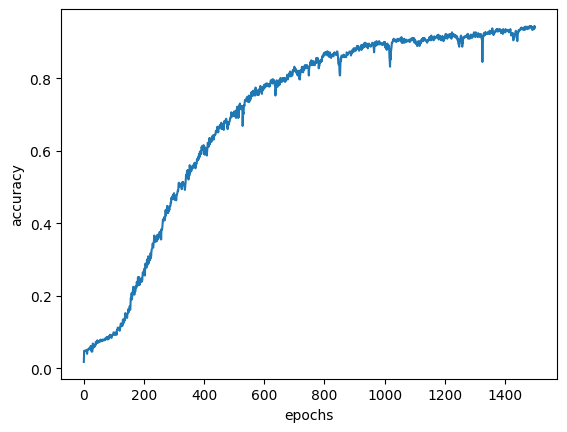

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

모델 정확도가 95%이므로 훈련 데이터에 있는 문자열을 주입하면 95% 확률로 정확하게 단어 예측.

그러나 텍스트를 생성할 때 이전에 본 적 없는 단어가 계속 나오므로 정확도가 높음에도 이상한 텍스트 생성한다.


### 8.3. 텍스트 생성하기
텍스트 시퀀스를 주입하고 다음 단어를 예측해보자

#### 8.3.1. 다음 단어 예측하기
시드 텍스트를 위한 구절을 만든다.

시드 텍스트는 신경망이 생성하는 콘텐츠의 기반이 되는 초기 표현이다. 신경망은 시드 텍스트의 다음 단어를 예측해 콘텐츠를 생성할 것이다.


In [ ]:
seed_text = 'in the town of athy'

In [ ]:
token_list = tokenizer.texts_to_sequences([seed_text])[0]

In [ ]:
token_list = pad_sequences([token_list],
                           maxlen=max_sequence_len-1, padding='pre')

In [ ]:
# 확인 코드
token_list1 = tokenizer.texts_to_sequences([seed_text])[0]

token_list3 = pad_sequences([token_list1],
                           maxlen=max_sequence_len-1, padding='pre') # 리스트로 묶어서 전달해야함 아니면 오류 뜸
print(token_list1)
print(token_list3)

[4, 2, 66, 8, 67]
[[ 0  0  0  0  0  4  2 66  8 67]]


이제 model.predict 호출. 이 메서드는 말뭉치에 있는 각 단어에 대한 확률 반환.

결과는 np.argmax 함수에 전달해 가장 큰 인덱스 찾는다.

In [ ]:
pred = np.argmax(model.predict(token_list), axis=1) # 열 방향
print(pred)

1/1 [==============================] - 1s 644ms/step
[68]


In [ ]:
tokenizer.index_word[68]

'one'

반환값은 68이다. 단어 인덱스를 보면 이 값은 단어 'one'에 해당

훈련데이터에 있는 노래 가사는 정확하게 예측했다.

#### 8.3.2. 예측을 연결해 텍스트 생성하기
신경망으로 새로운 텍스트를 만들려면 새로운 단어를 추가하면서 예측을 반복하면 된다.

예를 들어 앞서 'sweet jeremy saw dublin' 구절을 사용했을 때 다음 단어를 'then'으로 에측한다.

또 여기에서 'sweet jeremy saw dublin then'을 시드 텍스트로 이용하면 또 다른 예측을 얻을 수 있다.

이 과정을 반복하면 인공지능이 생성한 텍스트를 얻게 된다.

In [ ]:
seed_text = 'sweet jeremy saw dublin'
next_words = 10

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  pred = np.argmax(model.predict(token_list), axis=1)
  output_word = ''

  for word, index in tokenizer.word_index.items():
    if index == pred:
      output_word = word
      break
  seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 17ms/step
sweet jeremy saw dublin lanigans at and me long gray glisten her wall stepped


횡설수설하는 이상한 문장이 생성된다. 이유가 무엇일까?

1. 훈련 텍스트가 정말 작아 사용할 문맥이 거의 없기 때문이다.
2. 시퀀스의 다음 단어 예측이 이전 단어에 의존하기 떄문이다. 이전 단어의 예측이 좋지 못했다면 다음 단어를 잘 예측하더라도 적절할 확률이 낮다. 이 단어를 시퀀스에 추가하고 다음 단어를 예측하면 이 확률이 낮아질 가능성이 더 높아진다.

이러한 이유 때문에 예측한 단어가 거의 무작위한 것처럼 보이게 된다.


### 8.4. 데이터셋 확장하기
하드코딩한 데이터셋에 사용했던 패턴을 동일하게 간단한 텍스트 파일로 확장할 수 있다.

예제를 위해 여러 노래에서 수집한 1,700 줄의 텍스트를 사용해보겠다. 코드를 조금만 수정하면 하드 코딩한 텍스트 대신 이 파일을 사용할 수 있다.


In [6]:
!wget https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt

--2024-03-07 06:52:40--  https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘irish-lyrics-eof.txt’

irish-lyrics-eof.tx 100%[===================>]  67.35K   346KB/s    in 0.2s    

2024-03-07 06:52:41 (346 KB/s) - ‘irish-lyrics-eof.txt’ saved [68970/68970]



이 텍스트를 로드한다.

In [7]:
data = open('irish-lyrics-eof.txt').read()
corpus = data.lower().split('\n') # corpus는 말뭉치라는 뜻

In [8]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [9]:
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0] # list로 전달하지 않으면 매 토큰마다 적용되어 [[0],[123], [31]....] 이런 식으로 복잡해짐.
  # 리스트로 전달하면 [[0, 123, 32,...]]이므로 0번쨰 인덱스 호출
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1] # 부분 시퀀스
    input_sequences.append(n_gram_sequence)

In [10]:
max_sequence_len = max([len(x) for x in input_sequences])

input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen = max_sequence_len, padding='pre'))

xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 8))
model.add(Bidirectional(LSTM(max_sequence_len-1)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=1000, verbose=1)

Epoch 1/1000
377/377 [==============================] - 15s 29ms/step - loss: 6.8892 - accuracy: 0.0650
Epoch 2/1000
377/377 [==============================] - 7s 18ms/step - loss: 6.4094 - accuracy: 0.0657
Epoch 3/1000
377/377 [==============================] - 5s 14ms/step - loss: 6.3116 - accuracy: 0.0657
Epoch 4/1000
377/377 [==============================] - 5s 13ms/step - loss: 6.2503 - accuracy: 0.0657
Epoch 5/1000
377/377 [==============================] - 4s 9ms/step - loss: 6.1992 - accuracy: 0.0657
Epoch 6/1000
377/377 [==============================] - 4s 11ms/step - loss: 6.1500 - accuracy: 0.0659
Epoch 7/1000
377/377 [==============================] - 3s 8ms/step - loss: 6.0970 - accuracy: 0.0670
Epoch 8/1000
377/377 [==============================] - 3s 8ms/step - loss: 6.0375 - accuracy: 0.0694
Epoch 9/1000
377/377 [==============================] - 4s 10ms/step - loss: 5.9757 - accuracy: 0.0710
Epoch 10/1000
377/377 [==============================] - 3s 8ms/step - loss

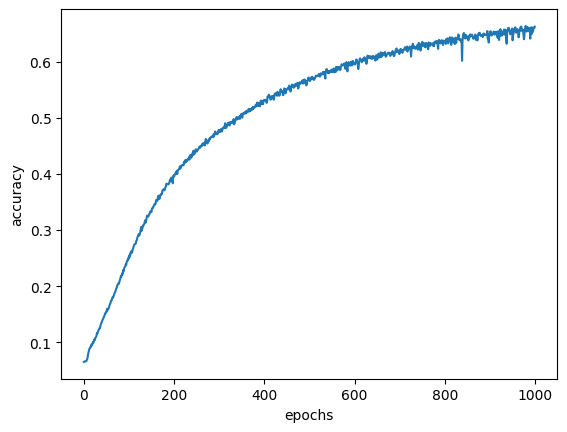

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

1,000 번의 에폭 동안 훈련하면 약 70%의 정확도를 달성하여 곡선이 평평해진다.

다시 'in the town of athy' 구문을 주입하면 'one'을 예측한다.


'sweet jeremy saw dublin' 의 경우 59% 확률로 'drawn'을 예측한다. 10개의 단어를 예측한 결과는 다음과 같다.

In [ ]:
seed_text = 'in the town of athy'
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list],
                           maxlen=max_sequence_len-1, padding='pre')

pred = np.argmax(model.predict(token_list), axis=1) # 리스트로 반환됨
print(model.predict(token_list))
print(tokenizer.index_word[pred[0]], pred)

1/1 [==============================] - 1s 688ms/step
one


In [ ]:
seed_text = "sweet jeremy saw dublin"
next_words=10
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list],  maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""

    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += (" " + output_word)

print(seed_text)

1/1 [==============================] - 0s 18ms/step
sweet jeremy saw dublin fol the band o the summer pianos dear may morning


조금 나아 보인다! 하지만 더 개선할 수 있을까?

###8.5. 모델 구조 바꾸기

모델 향상할 수 있는 한 가지 방법은 여러 개의 LSTM 층을 쌓는 형식으로 구조를 변경하는 것이다.

첫 번째 LSTM 층의 return_sequences를 True로 지정하면 된다.(출력층 빼고 True로)

In [11]:
model = Sequential()
model.add(Embedding(total_words, 8))
model.add(Bidirectional(LSTM(max_sequence_len-1, return_sequences=True)))
model.add(Bidirectional(LSTM(max_sequence_len-1)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=1000, verbose=1)

Epoch 1/1000
377/377 [==============================] - 21s 33ms/step - loss: 6.8496 - accuracy: 0.0645
Epoch 2/1000
377/377 [==============================] - 5s 13ms/step - loss: 6.3990 - accuracy: 0.0657
Epoch 3/1000
377/377 [==============================] - 5s 14ms/step - loss: 6.2909 - accuracy: 0.0657
Epoch 4/1000
377/377 [==============================] - 5s 12ms/step - loss: 6.2235 - accuracy: 0.0660
Epoch 5/1000
377/377 [==============================] - 5s 13ms/step - loss: 6.1525 - accuracy: 0.0705
Epoch 6/1000
377/377 [==============================] - 5s 12ms/step - loss: 6.0801 - accuracy: 0.0737
Epoch 7/1000
377/377 [==============================] - 4s 12ms/step - loss: 6.0146 - accuracy: 0.0756
Epoch 8/1000
377/377 [==============================] - 5s 14ms/step - loss: 5.9518 - accuracy: 0.0768
Epoch 9/1000
377/377 [==============================] - 4s 11ms/step - loss: 5.8998 - accuracy: 0.0790
Epoch 10/1000
377/377 [==============================] - 4s 12ms/step - 

시간이 엄청 오래 걸린다.

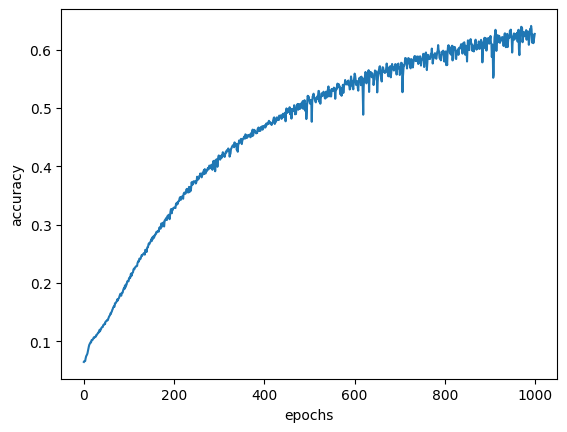

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [14]:
seed_text = 'in the town of athy'
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list],
                           maxlen=max_sequence_len-1, padding='pre')

pred = np.argmax(model.predict(token_list), axis=1) # 리스트로 반환됨
print(model.predict(token_list))
print(tokenizer.index_word[pred[0]], pred)

1/1 [==============================] - 0s 18ms/step
[[2.1863324e-11 9.4077430e-09 1.1203631e-02 ... 7.5439636e-32
  5.4651918e-30 4.1718893e-36]]
one [41]


In [15]:
seed_text = "sweet jeremy saw dublin"
next_words=10
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list],  maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""

    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += (" " + output_word)
print(seed_text)

1/1 [==============================] - 0s 19ms/step
sweet jeremy saw dublin and you for youths calico rattling than townland to sip


In [22]:
seed_text = "in the town athy"
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list],
                           maxlen=max_sequence_len-1, padding='pre')

pred = np.argmax(model.predict(token_list), axis=1) # 리스트로 반환됨
print(max(model.predict(token_list)[0]))
print(tokenizer.index_word[pred[0]], pred)

1/1 [==============================] - 0s 18ms/step
0.2167882
each [241]


다른 결과가 나오더라도 걱정 안해도 된다. 잘못된 것이 아니다. 뉴런의 랜덤 초기화가 마지막 점수에 영향을 미친 결과이다.

### 8.6. 데이터 계선하기


새로운 노래 가사를 추가하지 않고 데이터셋 크기를 늘릴 수 있는 **윈도잉** 이라는 간단한 트릭이 있다.

줄마다 이동해 처리하는 대신 모든 줄을 하나의 긴 텍스트처럼 다룬다.

그다음 윈도(window)를 만들어 n개의 단어를 처리하고 윈도를 한 단어 앞으로 이동헤 다음 입력 시퀀스를 생성한다. p.224 윈도 그림
***
이렇게 하면 훨씬 많은 훈련 데이터가 발생해 입력 시퀀스가 늘어난다. 전체 말뭉치 텍스트에 윈도를 이동 시키면

(number_of_words - window_size) * window_size 개를 훈련할 수 있는 입력 시퀀스를 얻을 수 있다.

간단하다. 데이터를 로딩할 때 각 줄을 하나의 문장으로 분리하는 대신 말뭉치에 있는 단어로 바로 만들 수 있다.

In [23]:
window_size = 10
sentences = []
alltext = []
data = open('irish-lyrics-eof.txt').read()
corpus = data.lower()
words = corpus.split(' ')

range_size = len(words) - window_size # 윈도우 사이즈로 이동(풀링이랑 비슷함)
for i in range(0, range_size):
  thissentence = '' # 부분 문장
  # 윈도 크기에 해당하는 단어 선택해 문장 만들기
  for word in range(0, window_size-1): # 윈도우에 들어가는 부분 문장 구함
    word = words[i+word]
    thissentence = thissentence + word
    thissentence = thissentence + ' '
  sentences.append(thissentence)

윈도와 같은 크기의 시퀀스를 만들었기 때문에 max_sequence_len이 윈도 크기가 된다.(?)

In [26]:
model = Sequential()
model.add(Embedding(total_words, 8))
model.add(Bidirectional(LSTM(window_size-1, return_sequences='True')))
model.add(Bidirectional(LSTM(window_size-1)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model.fit(xs, ys, epochs=1000, verbose=1)

Epoch 1/1000
377/377 [==============================] - 16s 28ms/step - loss: 6.8991 - accuracy: 0.0651
Epoch 2/1000
377/377 [==============================] - 5s 13ms/step - loss: 6.4078 - accuracy: 0.0657
Epoch 3/1000
377/377 [==============================] - 5s 14ms/step - loss: 6.3047 - accuracy: 0.0657
Epoch 4/1000
377/377 [==============================] - 4s 12ms/step - loss: 6.2483 - accuracy: 0.0657
Epoch 5/1000
377/377 [==============================] - 5s 13ms/step - loss: 6.2075 - accuracy: 0.0657
Epoch 6/1000
377/377 [==============================] - 5s 13ms/step - loss: 6.1734 - accuracy: 0.0669
Epoch 7/1000
377/377 [==============================] - 5s 12ms/step - loss: 6.1372 - accuracy: 0.0676
Epoch 8/1000
377/377 [==============================] - 5s 14ms/step - loss: 6.1004 - accuracy: 0.0684
Epoch 9/1000
377/377 [==============================] - 4s 12ms/step - loss: 6.0634 - accuracy: 0.0696
Epoch 10/1000
377/377 [==============================] - 4s 11ms/step - 

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

데이터가 늘어났기 때문에 훈련속도가 훨씬 느리다. 하지만 결과는 크게 향상된다.

(너무 느려서 생략)

즉, 생성된 텍스트가 횡설수설이 되기까지 훨씬 오래 걸린다.

문장을 생성해보자

In [27]:
seed_text = "sweet jeremy saw dublin"
next_words=10
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list],  maxlen=window_size-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""

    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 17ms/step
sweet jeremy saw dublin be and the loo loo loo loo loo loo ballyjamesduff


### 하이퍼 파라미터 튜닝

튜닝할 수 있는 하이퍼파리미터가 많다. 윈도 크기를 변경하면 훈련 데이터의 양이 바뀐다.

윈도 크기가 작으면 데이터가 더 많지 만들어지지만, 하나의 레이블에 매핑되는 단어는 더 적어진다.

따라서 윈도 크기를 너무 작게 만들면 이해할 수 없는 글이 생성된다.

임베딩 차원, LSTM의 뉴런 개수, 어휘 사전 크기를 바꿀 수 있다. 정확도가 최선의 측정 지표는 아니다.

그러나 모델이 좋은지 나쁜지 결정할 수 있는 간편하고 확실한 방법은 없다.

예를 들어 윈도 크기를 6으로 하고, 임베딩 차원을 16으로 늘리고,

LSTM 뉴런 개수를(윈도 크기 6이 아니라) 32로 바꾸고,

Adam 옵티마이저의 학습률을 높여보겠다.



In [28]:
window_size = 6
sentences = []
alltext = []
range_size = len(words)-window_size
for i in range(0, range_size):
    thissentence=""
    for word in range(0, window_size-1):
        word = words[i+word]
        thissentence = thissentence + word
        thissentence = thissentence + " "
    sentences.append(thissentence)

In [29]:
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Embedding(total_words, 16))
model.add(Bidirectional(LSTM(32, return_sequences='True')))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam,
              metrics=['accuracy'])
history = model.fit(xs, ys, epochs=100, verbose=1)

Epoch 1/100
377/377 [==============================] - 45s 31ms/step - loss: 6.6978 - accuracy: 0.0650
Epoch 2/100
377/377 [==============================] - 6s 16ms/step - loss: 6.2485 - accuracy: 0.0729
Epoch 3/100
377/377 [==============================] - 5s 12ms/step - loss: 6.0121 - accuracy: 0.0917
Epoch 4/100
377/377 [==============================] - 4s 12ms/step - loss: 5.7963 - accuracy: 0.1061
Epoch 5/100
377/377 [==============================] - 5s 13ms/step - loss: 5.6181 - accuracy: 0.1156
Epoch 6/100
377/377 [==============================] - 4s 12ms/step - loss: 5.4305 - accuracy: 0.1230
Epoch 7/100
377/377 [==============================] - 5s 14ms/step - loss: 5.2408 - accuracy: 0.1318
Epoch 8/100
377/377 [==============================] - 4s 11ms/step - loss: 5.0619 - accuracy: 0.1430
Epoch 9/100
377/377 [==============================] - 4s 12ms/step - loss: 4.9453 - accuracy: 0.1514
Epoch 10/100
377/377 [==============================] - 5s 13ms/step - loss: 4.72

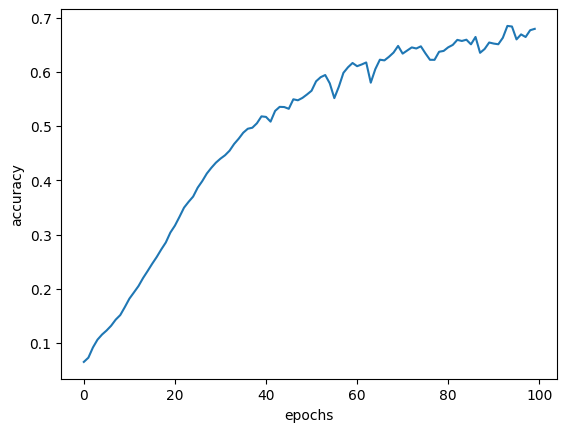

In [30]:
plt.plot(history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

부드럽고 훌륭한 정확도 곡선을 얻었다.

만들어진 가사도 훨씬 낫다.?... 모르겠다

In [31]:
seed_text = "sweet jeremy saw dublin"
next_words=10
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list],  maxlen=window_size-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""

    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 28ms/step
sweet jeremy saw dublin the barley and setting my blessing by gem it is


### 8.7. 문자 기반 인코딩

여태까지 단어 기반 인코딩을 사용한 자연어 처리 작업을 알아보았다.

시작하기에는 이 방법이 좋지만 텍스트를 생성할 때는 **문자 기반 인코딩**을 고려할 수 있다.

말뭉치에 있는 고유한 문자의 개수가 고유한 단어의 개수보다 훨씬 적기 떄문이다.

따라서 출력층에 훨씬 적은 뉴런을 둘 수 있고, 출력 예측이 적은 개수의 확률로 나눠진다.

예시론 익스피어 데이터셋(https://oreil.ly/XW_ab)에는 고유 문자 65개 뿐이다.

따라서 예측을 만들 때 아일랜드 노래 데이터셋에 있는 2,700개의 단어에서 다음 단어를 고르는 것이 아니라

65개만 보면 된다. 모델이 간단해진다.

**문자 인코딩의 또 다른 장점** 은 구두점 문자도 포함된다는 것이다.

 따라서 줄 바꿈 등과 같은 문자도 예측할 수 있다.

 셰익스피어 데이터셋 같은 데이터를 훈련 데이터로 사용하면 익숙하지 않은 언어이므로 조금 관대해지는 경향이 있다.(이해하기 어려운 텍스트가 출력되기도 한다.)